# Number plate recognition in image

이미지 데이터 출처: https://github.com/openalpr/benchmarks

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

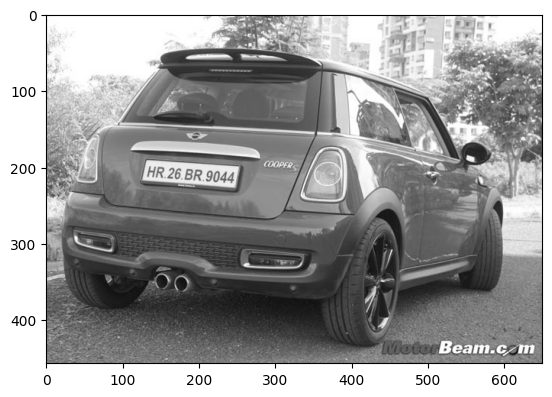

In [6]:
img = cv2.imread('images/image1.jpg') # img로 이미지를 읽어옴
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 사진 속 색 변경(BGR2GRAY: blue, green, red to gray)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)) # cv2는 색 순서가 BGR이고 plt은 RGB순서이다.

## 2. Apply filter and find edges for localization

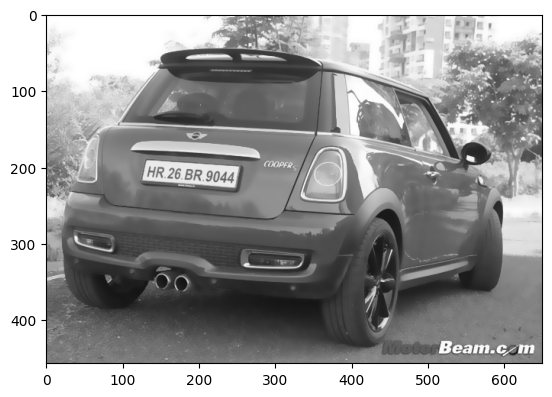

In [7]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # noise reduction(흐림효과, 계산을 빠르고 정확하게 진행)
edged = cv2.Canny(bfilter, 30, 200) # Edge detection(가장자리 검출)
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB)) # 흐림효과 결과

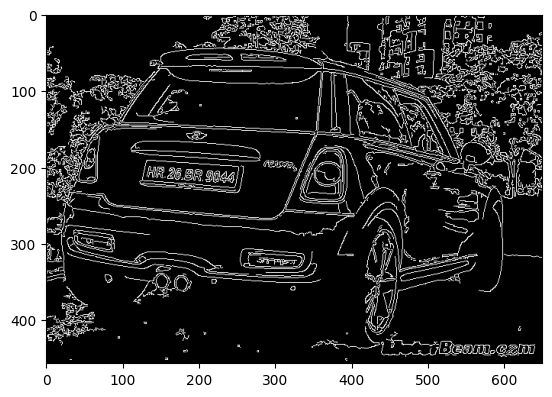

In [8]:
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB)) # 가장자리 검출 결과

## 3. Find Contours and Apply Mask

In [9]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 윤곽선 검출
contours = imutils.grab_contours(keypoints) # 
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # 크기가 큰 top10

In [6]:
# 사각형(번호판)인지 판단 후 필터
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [7]:
location # 번호판 꼭지점 위치

array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

In [8]:
# 위에서 얻은 꼭지점으로 번호판이외에 마스킹 진행
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

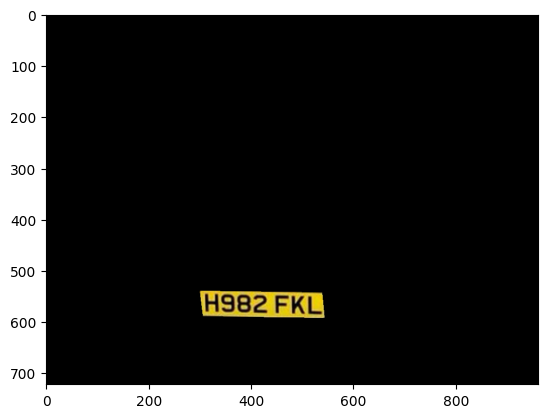

In [9]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [10]:
# 번호판만 추출
(x,y) = np.where(mask==255) # 검은색으로 마스킹 되지 않은 범위
(x1, y1) = (np.min(x), np.min(y)) # 좌상점
(x2, y2) = (np.max(x), np.max(y)) # 우하점
cropped_image = gray[x1:x2+1, y1:y2+1] # 회색조 사진에서 크롭

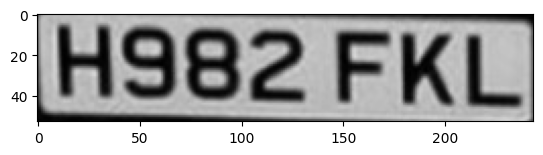

In [11]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [12]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


: 

: 

## 5. Render Result

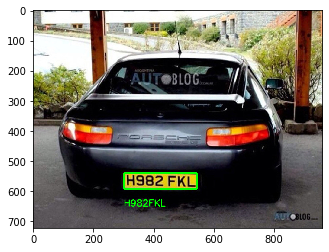

In [100]:
# 이미지 위에 표시
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))